# Gemeinderatswahl 2024 in Freiburg

Hier sage ich die Gemeinderatswahlergbnisse aus Freiburg im Breisgau vorher.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import os
from matplotlib import pyplot as plt
import json
#import plotly.express as px
#import plotly.graph_objects as go
import geopandas 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')
from functions_wahl import *

In [2]:
#Daten bekommen und kombinieren mit geografischen und statistischen Stadtdaten 
#get_and_save_komm()
Stadtteile,Stadtbezirke=process_geo()
gesamt,comb2,wahl_bezirke=get_process_wahl(final=False)
joined=Stadtbezirke.join(comb2)
gem19_stadtbezirke=get_gem19()    
gesamt=combiniere_19(gesamt,gem19_stadtbezirke,area='gesamt')
joined=combiniere_19(joined,gem19_stadtbezirke,area='Stadtbezirke')

Wahlbezirke 247
ausgezaehlte Wahlbezirke 52


## Gesamtergebnis

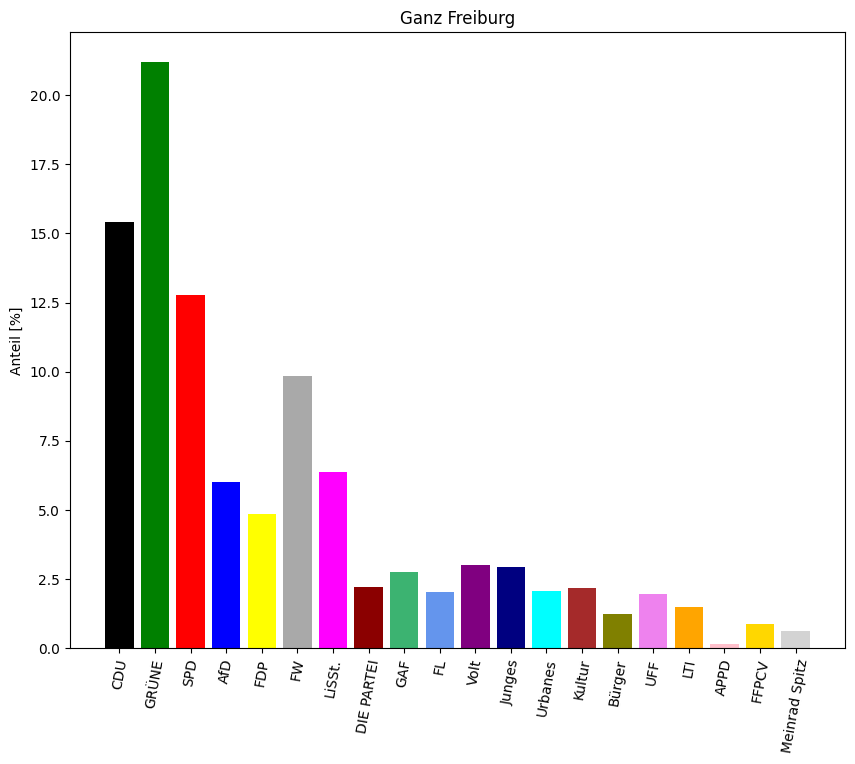

In [3]:
make_bar_plot(gesamt,title='Ganz Freiburg')

Veraenderung. 

Buergerliches Lager Veraenderung: 5.7 %
Linken Lager Veraenderung: -7.9 %
rechtsextreme Veraenderung: 2.4 %
Sonstige: Veraenderung: 0.1 %


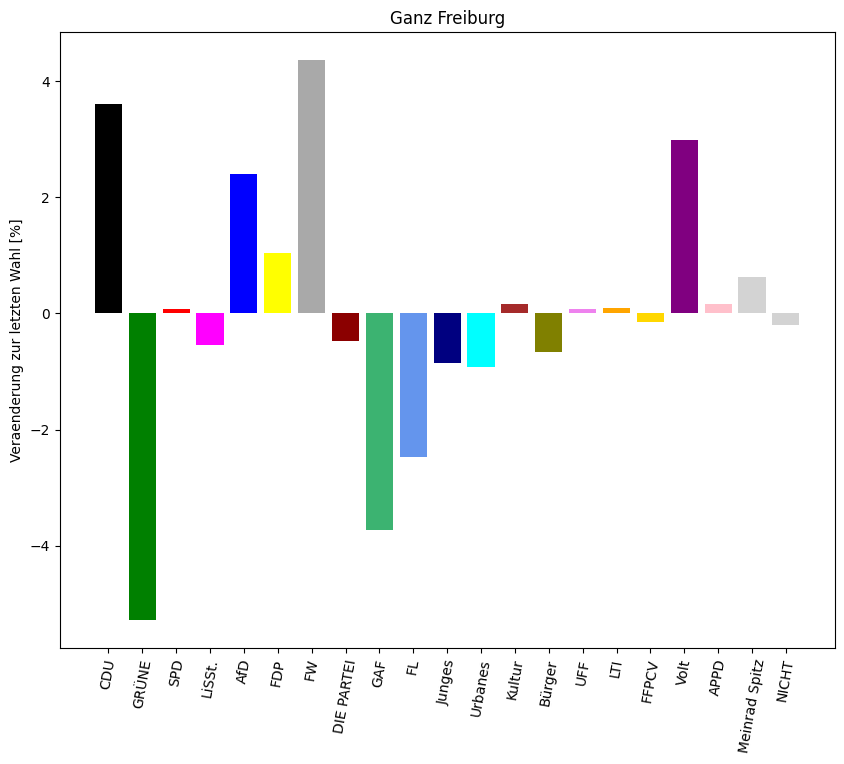

In [4]:
print(f"Buergerliches Lager Veraenderung: {np.round(gesamt.loc[0,['CDU_differenz','Bürger_F_differenz','FFPCV_differenz','FDP_differenz','FL_differenz','FW_differenz']].sum(),1)} %")
print(f"Linken Lager Veraenderung: {np.round(gesamt.loc[0,['GRÜNE_differenz','SPD_differenz','GAF_differenz','Volt_differenz','Junges_F_differenz','LiSSt._differenz','Urbanes_F_differenz','Kultur_differenz','UFF_differenz','LTI_differenz']].sum(),1)} %")
print(f"rechtsextreme Veraenderung: {np.round(gesamt.loc[0,['AfD_differenz',]].sum(),1)} %")
print(f"Sonstige: Veraenderung: {np.round(gesamt.loc[0,['DIE_PARTEI_differenz','NICHT_differenz','APPD_differenz','Meinrad_Spitz_differenz']].sum(),1)} %")

make_bar_plot(gesamt,title='Ganz Freiburg',diff=True)

Allerdings ist nach 52 Wahlbezirken das Ergebnis nicht repraesentativ.

In Sitzen nun. 

 48 wurden zugeteilt wie es sein sollte


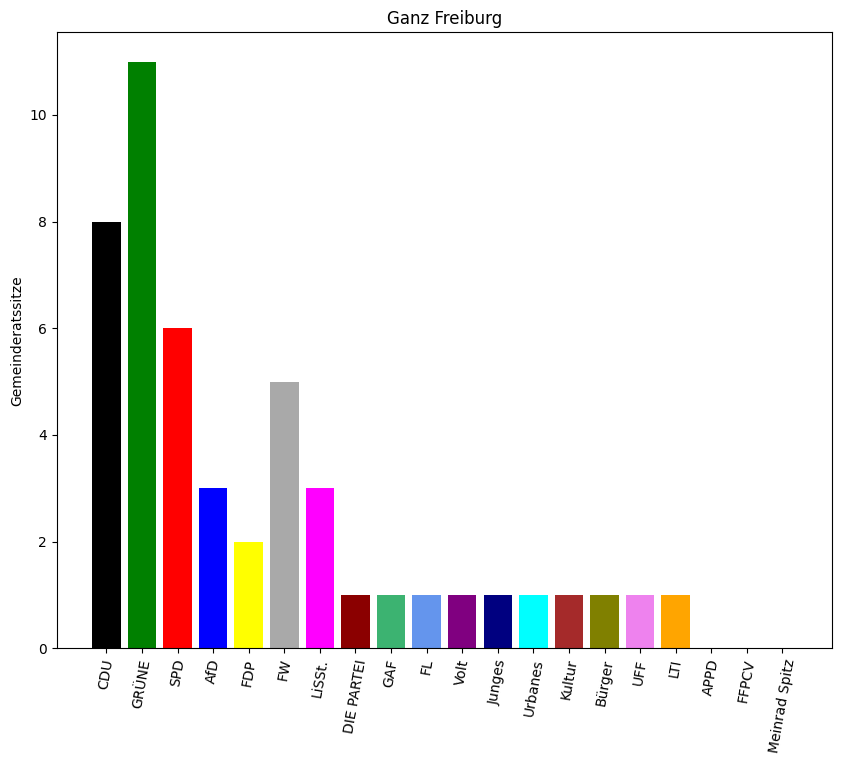

In [5]:
test_res=sainte_l(gesamt.loc[0,:])
make_bar_plot(gesamt,sitze=48,title='Ganz Freiburg')

Veraenderung zu 2019.

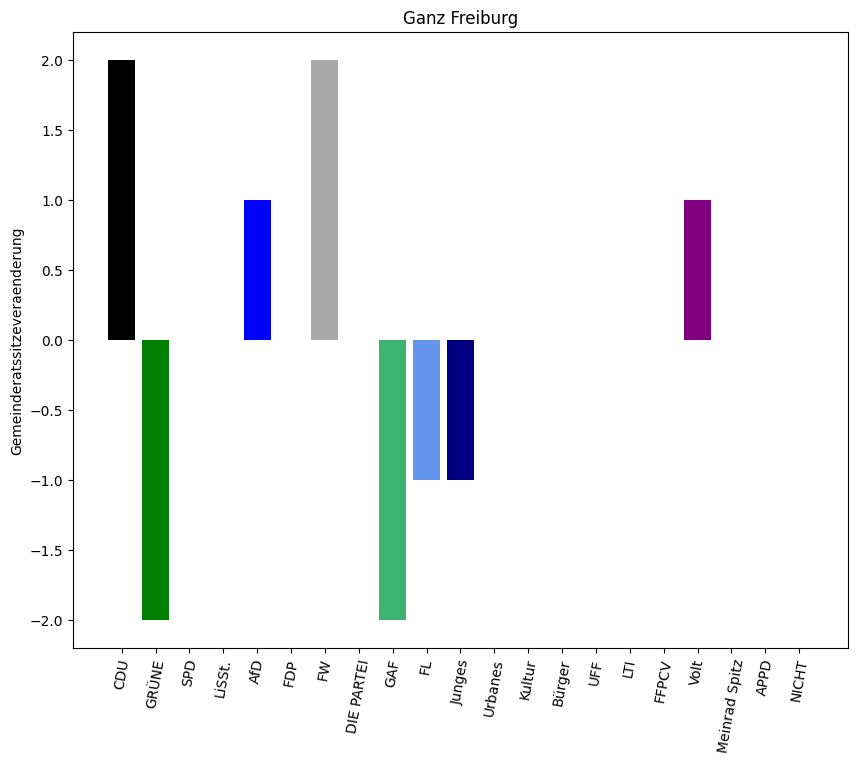

In [6]:
make_bar_plot(gesamt,sitze=48,title='Ganz Freiburg',diff=True)

Dabei ist zu beachten, dass noch lange nicht alles ausgezaehlt ist.

## Karten 
Zunaechst wieviel ausgezaehlt ist. 

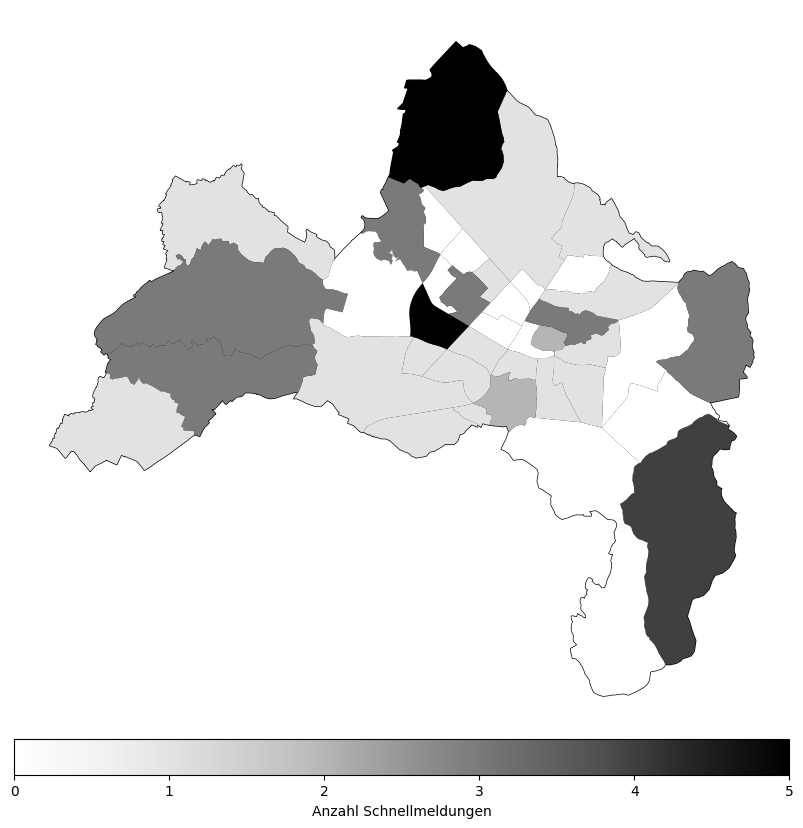

In [7]:
karte_stadtbezirke(joined,'anz-schnellmeldungen')

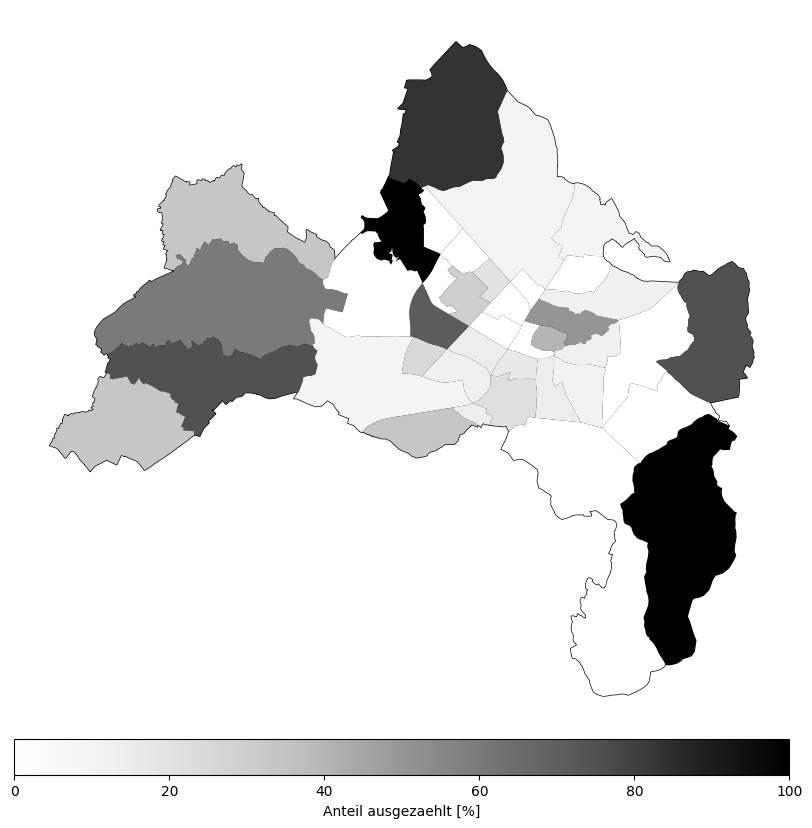

In [8]:
karte_stadtbezirke(joined,'wahlbezirke_prozent')

Nun Karten mit Parteianteil. 

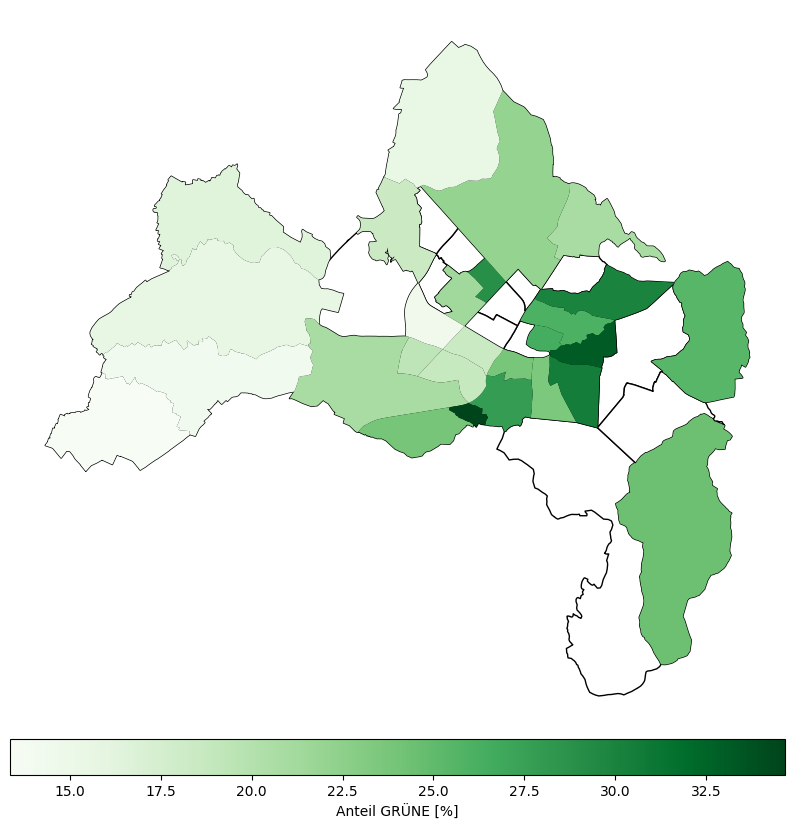

In [9]:
karte_stadtbezirke(joined,'GRÜNE')

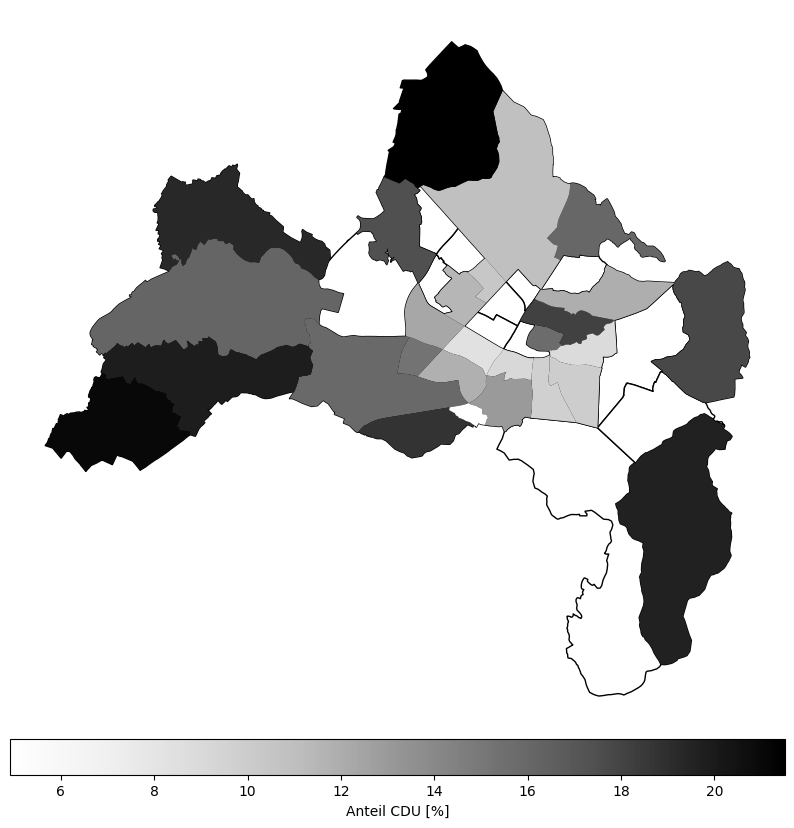

In [10]:
karte_stadtbezirke(joined,'CDU')

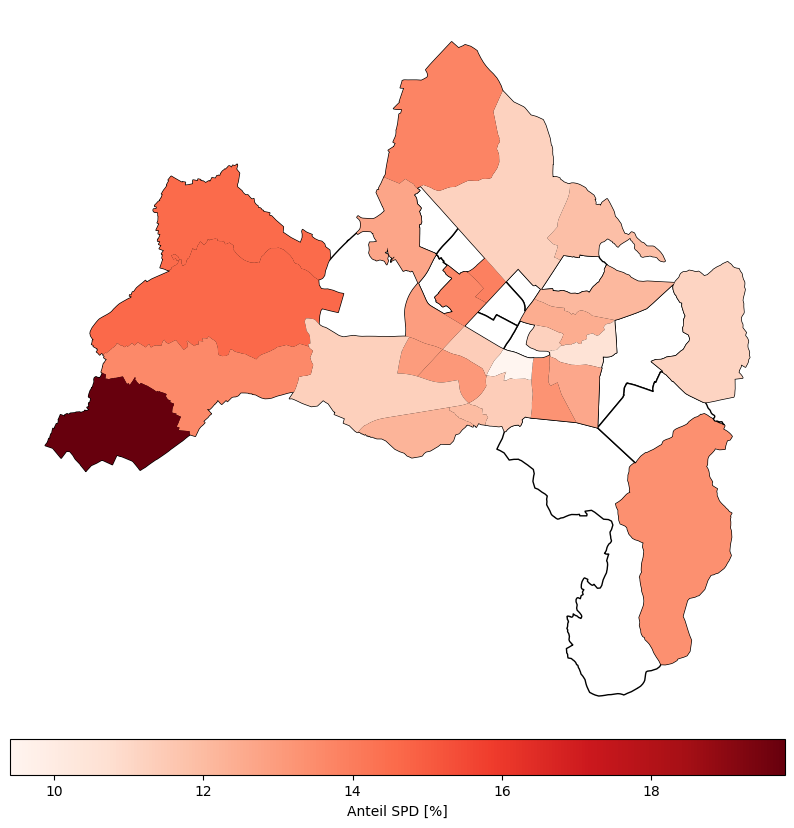

In [11]:
karte_stadtbezirke(joined,'SPD')

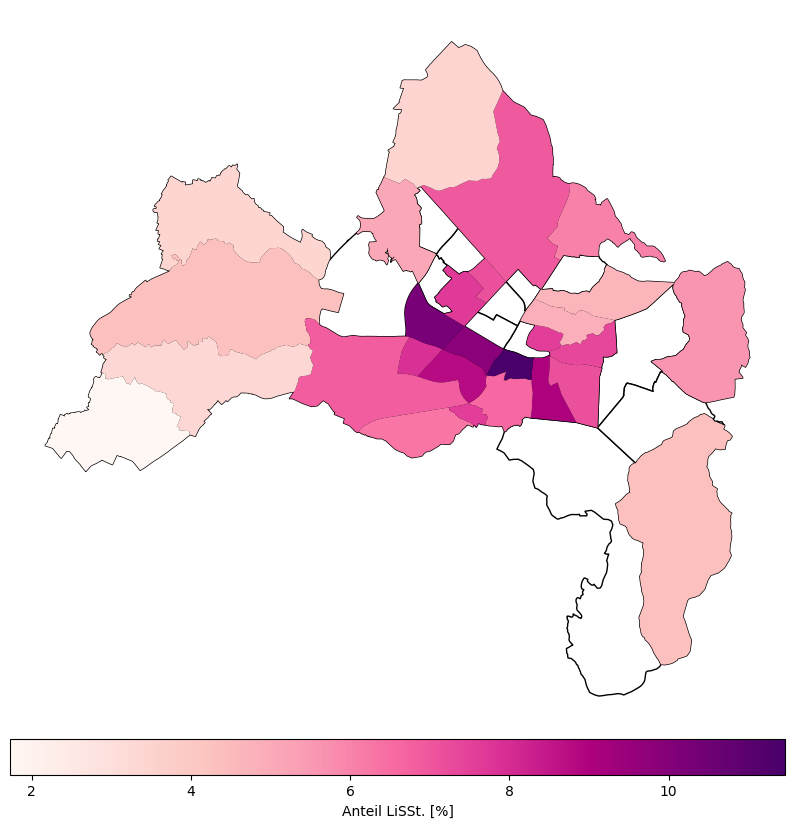

In [12]:
karte_stadtbezirke(joined,'LiSSt.')

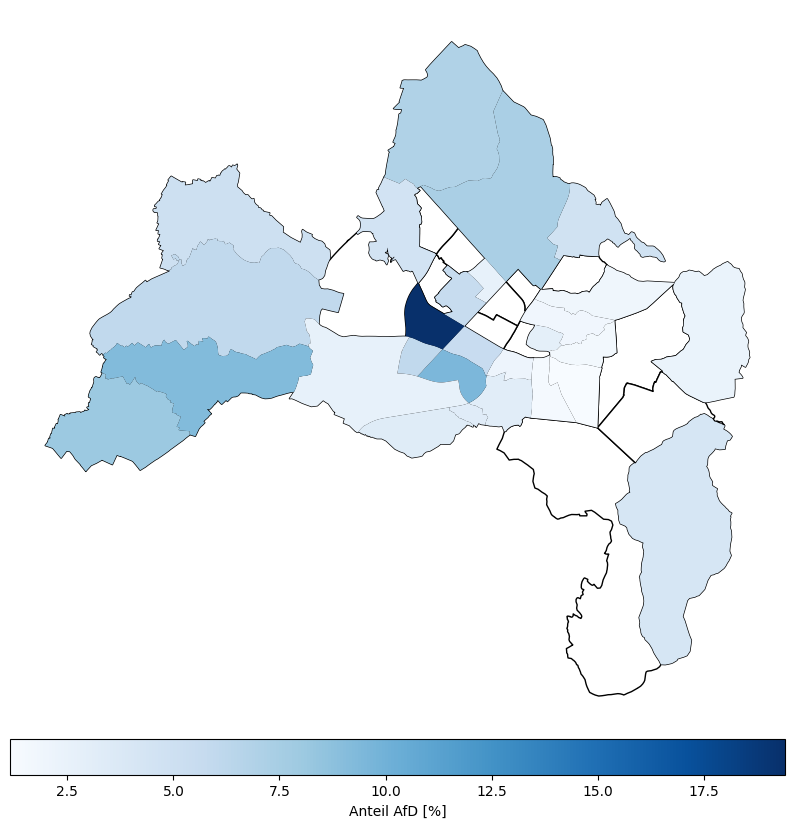

In [13]:
karte_stadtbezirke(joined,'AfD')

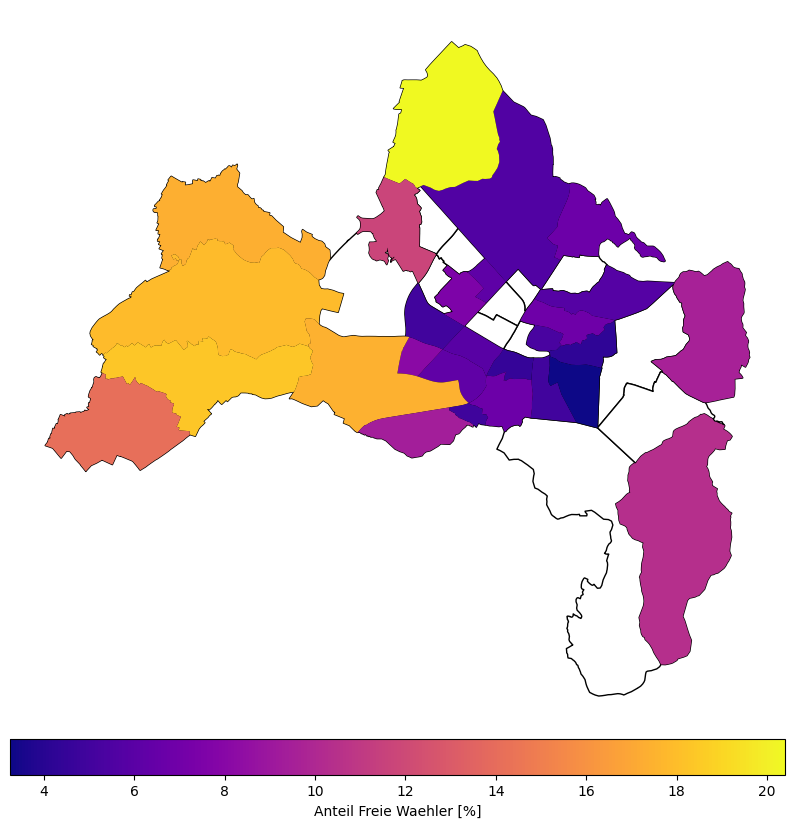

In [14]:
karte_stadtbezirke(joined,'FW')

## Gesamtergebniss Vorhersage.

Die Fertigsten Stadtbezirke helfen um das Gesamtergebnis Vorherzusagen. 

In [15]:
print((comb2.loc[:,'anz-schnellmeldungen']/comb2.loc[:,'max-schnellmeldungen']).sort_values(ascending=False)[0:6])

Stadtbezirk
Lehen         1.000000
Kappel        1.000000
Hochdorf      0.833333
Tiengen       0.750000
Ebnet         0.750000
Weingarten    0.714286
dtype: float64


Zunaechst Kappel. 

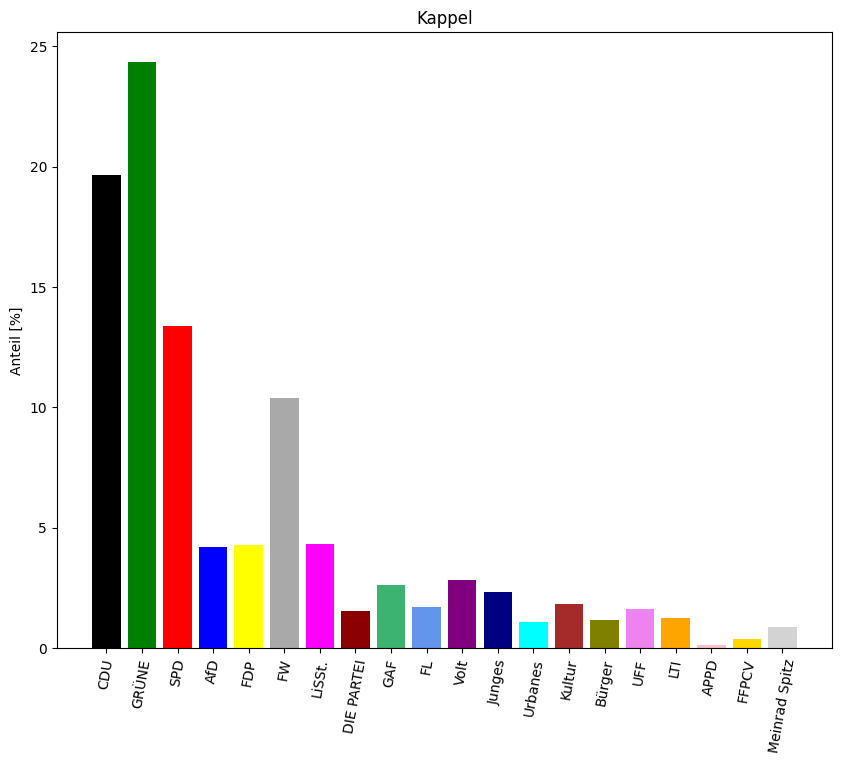

In [16]:
make_bar_plot(joined,index='Kappel',title='Kappel')

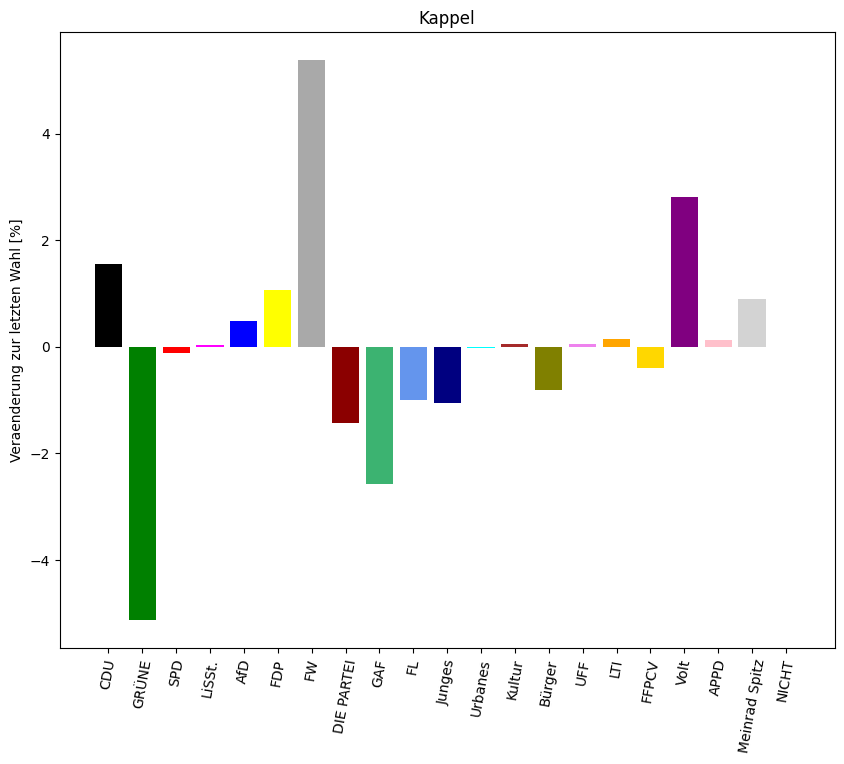

In [17]:
make_bar_plot(joined,index='Kappel',title='Kappel',diff=True)

Dann Lehen. 

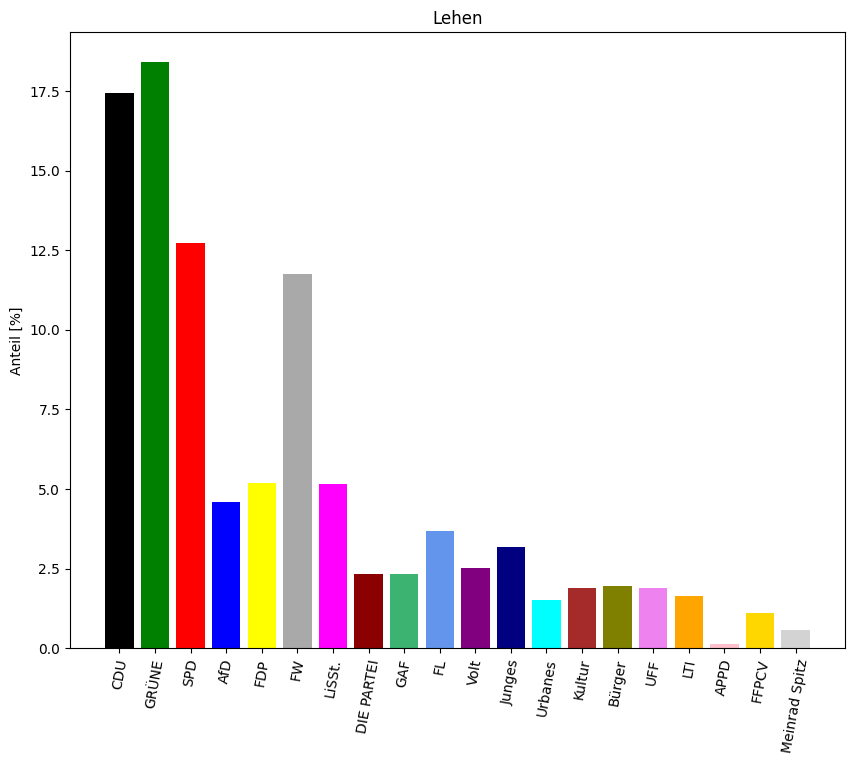

In [25]:
make_bar_plot(joined,index='Lehen',title='Lehen')

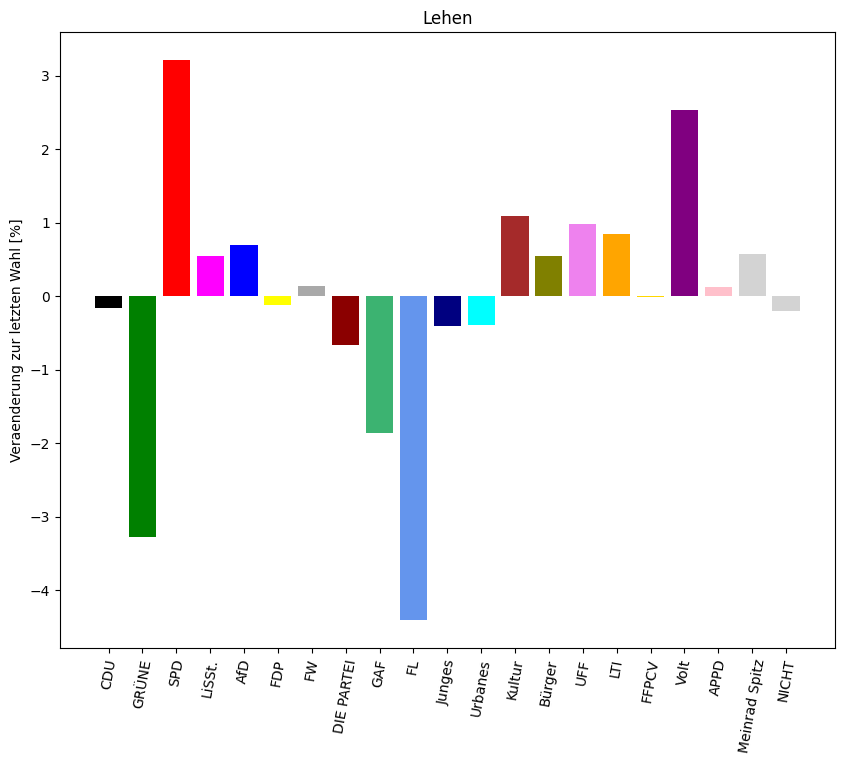

In [26]:
make_bar_plot(joined,index='Lehen',title='Lehen',diff=True)

Die Werte sind wie zu erwarten verschiedener als die Veraenederunge, aber auch die Veraenderungen zeigen noch eine deutliche Streuung. 

Nun Verwendung der Wahlbezirke der Europawahl. Das hat den Vorteil, dass die Wahlbezirke genau die selben waren und man so auf die nur teilweise ausgezaehlten Stadtbezirke ohne Variationsrisikio verwenden kann. 

In [27]:
eu_wahlbezirke=pd.read_csv('eu24_wahlbezirke.csv',sep=';')
wahl_bezirke=get_percent(wahl_bezirke)
tot_eu=pd.read_csv('eu24_summe.csv',sep=';')
eu_wahlbezirke=get_percent(eu_wahlbezirke,wahl='Europa')
com_wahlbezirke=pd.merge(wahl_bezirke,eu_wahlbezirke, how='inner', left_on='gebiet-nr',right_on='gebiet-nr',suffixes=('_gem24', '_eu24'))

Ich unter zuerst Korrelationen mit den Stimmen der Parteien in der Europawahl. 
Zur Auswahl wird der  Betrag der Korrelation verwendet um die Beste zu ermitteln, da fuer eine Vorhersage eione gute Antikorrelation genauso gut ist. 

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
def quatf(x,a,b,c):
    return a+x*b+x**2*c

In [46]:
def corr_predict(df,tot_eu,mode='diff',n_party=1,silent=False,linear=True):
    partei_gem=['CDU',
       'GRÜNE', 'SPD', 'AfD', 'FDP', 'FW', 'LiSSt.', 'DIE_PARTEI', 'GAF',
       'FL', 'Volt', 'Junges_F', 'Urbanes_F', 'Kultur', 'Bürger_F',
       'UFF', 'LTI', 'APPD', 'FFPCV', 'Meinrad_Spitz']
    eu_parteien=[ 'CDU',
       'GRÜNE', 'SPD', 'AfD', 'FDP', 'FW', 'LINKE', 'DIE_PARTEI', 'Tierschutz',
       'ÖDP', 'Volt', 'Piraten', 'Familien', 'MERA25', 'Bündnis_C',
       'Aktion_Tierschutz', 'BIG', 'HEIMAT', 'PdH', 'PfSV', 'MW', 'MLPD',
       'DKP', 'SGP', 'ABG', 'dieBasis', 'B_Deutschland', 'BSW', 'DAVA',
       'Klimaliste', 'Letzte_Generation', 'PDV', 'PdF', 'PVVV']
    col=partei_gem[0]
    sel=df[(df[col].isna()==False)]
    resp=np.zeros((len(partei_gem)+1))
    for j in range(len(partei_gem)):
        party=partei_gem[j]
        col=party+'_prozent_gem24'
        corrs=np.zeros((4,len(eu_parteien)))
        for i in range(len(eu_parteien)):
            ar=np.zeros((2,sel.shape[0]))
            ar[0]=sel[eu_parteien[i]+'_prozent_eu24']
            if mode=='value':
                ar[1]=sel[party+'_prozent_gem24']            
            corr=np.corrcoef(ar[0],ar[1])
            corrs[0,i]=np.abs(corr[0,1])
            corrs[1,i]=corr[0,1] 
            s=np.argsort(-corrs[0])
        if silent==False:     
            print(f"Fuer Gem Liste {party} EU {eu_parteien[s[0]]} has the biggest |corr| of {corrs[1,s[0]]}")
        if n_party==1:
            ar=np.zeros((2,sel.shape[0]))
            ar[0]=sel[eu_parteien[s[0]]+'_prozent_eu24']
            if mode=='diff':
                ar[1]=sel[party+'_prozent_gem24']-sel[parteien[s[0]]+'_prozent_eu24']
            elif mode=='value':
                ar[1]=sel[party+'_prozent_gem24']
            if linear==True:
                res,cov=sp.optimize.curve_fit(linf,ar[0],ar[1])
            else:
                res,cov=sp.optimize.curve_fit(quatf,ar[0],ar[1])                
        else:    
            ar=np.zeros((n_party+1,sel.shape[0]))
            for i in range(n_party):
                ar[i]=sel[eu_parteien[s[i]]+'_prozent_eu24']
            if silent==False:    
                 print(f"second best EU {eu_parteien[s[1]]} with |corr| of {corrs[1,s[1]]}")
            if mode=='value':
                ar[n_party]=sel[party+'_prozent_gem24']
            regr =LinearRegression()
            regr.fit(ar[0:n_party,:].T,ar[n_party,:])
        if n_party==1:    
            eu_anteil=np.array(tot_eu[eu_parteien[s[0]]]/tot_eu['Gueltige_Stimmen'])*100
        else:
            eu_anteil=np.zeros((2,n_party))
            for i in range(n_party):
                eu_anteil[:,i]=np.array(tot_eu[eu_parteien[s[i]]]/tot_eu['Gueltige_Stimmen'])*100
        if n_party==1:
            if mode=='value':
                if linear==True:
                    gem_anteil=linf(eu_anteil,res[0],res[1])
                else:
                    gem_anteil=quatf(eu_anteil,res[0],res[1],res[2])                    
        else:        
            if mode=='value':
                gem_anteil=regr.predict(eu_anteil)[0]
        resp[j]=gem_anteil
    resp[0:-1]=resp[0:-1]/np.sum(resp)*tot_eu.Gueltige_Stimmen[0]*48
    resp[-1]=np.sum(resp)
    partei_gem.append('Gueltige_Stimmen')
    prediction=pd.DataFrame(data=resp,index=partei_gem).T
    if silent==False:
        print("Vorhergesage Prozent Zahlen")
        print(((100*prediction/prediction.loc[0,'Gueltige_Stimmen']).round(1)).T)
    return prediction

Zunaechst fit mit nur einer Partei.  

In [47]:
prediction_val=corr_predict(com_wahlbezirke,tot_eu,mode='value')

Fuer Gem Liste CDU EU CDU has the biggest |corr| of 0.8913876999812103
Fuer Gem Liste GRÜNE EU GRÜNE has the biggest |corr| of 0.9256883452125154
Fuer Gem Liste SPD EU SPD has the biggest |corr| of 0.6601097006980841
Fuer Gem Liste AfD EU AfD has the biggest |corr| of 0.965023205132952
Fuer Gem Liste FDP EU FDP has the biggest |corr| of 0.7166911852308928
Fuer Gem Liste FW EU CDU has the biggest |corr| of 0.8299597658238668
Fuer Gem Liste LiSSt. EU CDU has the biggest |corr| of -0.7923596377908768
Fuer Gem Liste DIE_PARTEI EU DIE_PARTEI has the biggest |corr| of 0.5671763631234408
Fuer Gem Liste GAF EU CDU has the biggest |corr| of -0.6787279627618438
Fuer Gem Liste FL EU PdF has the biggest |corr| of 0.33605391778200205
Fuer Gem Liste Volt EU Volt has the biggest |corr| of 0.7708183507573724
Fuer Gem Liste Junges_F EU CDU has the biggest |corr| of -0.5839232271007679
Fuer Gem Liste Urbanes_F EU CDU has the biggest |corr| of -0.6791802793539722
Fuer Gem Liste Kultur EU GRÜNE has the bi

Hier Testplots der Korrelation. 

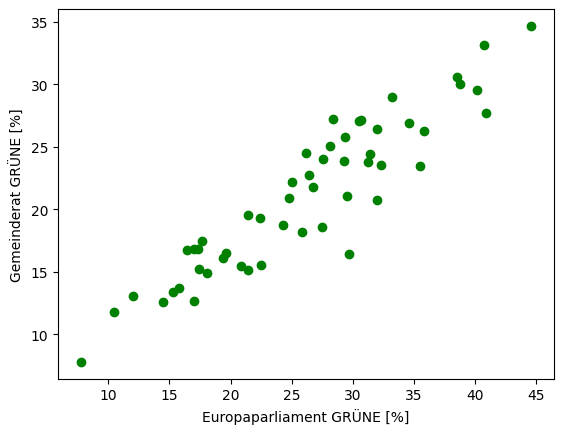

In [81]:
partei_gem=['CDU',
       'GRÜNE', 'SPD', 'AfD', 'FDP', 'FW', 'LiSSt.', 'DIE_PARTEI', 'GAF',
       'FL', 'Volt', 'Junges_F', 'Urbanes_F', 'Kultur', 'Bürger_F',
       'UFF', 'LTI', 'APPD', 'FFPCV', 'Meinrad_Spitz']
eu_parteien=[ 'CDU',
       'GRÜNE', 'SPD', 'AfD', 'FDP', 'FW', 'LINKE', 'DIE_PARTEI', 'Tierschutz',
       'ÖDP', 'Volt', 'Piraten', 'Familien', 'MERA25', 'Bündnis_C',
       'Aktion_Tierschutz', 'BIG', 'HEIMAT', 'PdH', 'PfSV', 'MW', 'MLPD',
       'DKP', 'SGP', 'ABG', 'dieBasis', 'B_Deutschland', 'BSW', 'DAVA',
       'Klimaliste', 'Letzte_Generation', 'PDV', 'PdF', 'PVVV']
col=partei_gem[0]
sel=com_wahlbezirke[(com_wahlbezirke[col].isna()==False)]
for j in range(1,2):
    party=partei_gem[j]
    col=party+'_prozent_gem24'
    corrs=np.zeros((2,len(eu_parteien)))
    for i in range(len(eu_parteien)):
        ar=np.zeros((2,sel.shape[0]))
        ar[0]=sel[eu_parteien[i]+'_prozent_eu24']
        ar[1]=sel[party+'_prozent_gem24']
        corr=np.corrcoef(ar[0],ar[1])      
        corrs[0,i]=np.abs(corr[0,1])     
        corrs[1,i]=(corr[0,1])         
    s=np.argmax(corrs[0])
    ar[0]=sel[eu_parteien[s]+'_prozent_eu24']
    ar[1]=sel[party+'_prozent_gem24']
    res,cov=sp.optimize.curve_fit(linf,ar[0],ar[1])
    plt.plot(ar[0],ar[1],'o',color='green')
    #um werte zu gewichten
    qs=eu_wahlbezirke[eu_parteien[s]+'_prozent_eu24'].quantile([0.2,0.4,0.6,0.8])
    #spaeter fuer gewichtung
    #print(qs)
    qs2=sel[eu_parteien[s]+'_prozent_eu24'].quantile([0.2,0.4,0.6,0.8])
    #print(qs2)
    plt.xlabel('Europaparliament '+eu_parteien[s]+' [%]')
    plt.ylabel('Gemeinderat '+party+' [%]')    

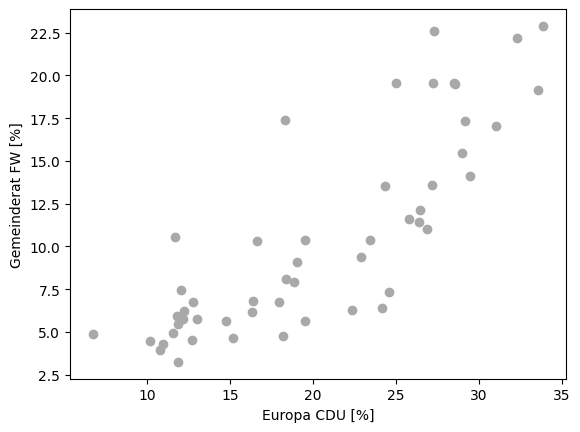

In [49]:
for j in range(5,6):
    party=partei_gem[j]
    col=party+'_prozent_gem24'
    corrs=np.zeros((2,len(eu_parteien)))
    for i in range(len(eu_parteien)):
        ar=np.zeros((2,sel.shape[0]))
        ar[0]=sel[eu_parteien[i]+'_prozent_eu24']
        ar[1]=sel[party+'_prozent_gem24']
        corr=np.corrcoef(ar[0],ar[1])      
        corrs[0,i]=np.abs(corr[0,1])     
        corrs[1,i]=(corr[0,1])         
    s=np.argmax(corrs[0])
    ar[0]=sel[eu_parteien[s]+'_prozent_eu24']
    ar[1]=sel[party+'_prozent_gem24']
    res,cov=sp.optimize.curve_fit(linf,ar[0],ar[1])
    plt.plot(ar[0],ar[1],'o',color='darkgray')
    #um werte zu gewichten
    qs=eu_wahlbezirke[eu_parteien[s]+'_prozent_eu24'].quantile([0.2,0.4,0.6,0.8])
    #print(qs)
    qs2=sel[eu_parteien[s]+'_prozent_eu24'].quantile([0.2,0.4,0.6,0.8])
    #print(qs2)
    plt.xlabel('Europa '+eu_parteien[s]+' [%]')
    plt.ylabel('Gemeinderat '+party+' [%]')    

Freie Waehler einer der weniger die sichtbar nicht linear Aussieht.

Test mit quadratisch fuer alle. 

In [50]:
prediction_val_q=corr_predict(com_wahlbezirke,tot_eu,mode='value',linear=False)

Fuer Gem Liste CDU EU CDU has the biggest |corr| of 0.8913876999812103
Fuer Gem Liste GRÜNE EU GRÜNE has the biggest |corr| of 0.9256883452125154
Fuer Gem Liste SPD EU SPD has the biggest |corr| of 0.6601097006980841
Fuer Gem Liste AfD EU AfD has the biggest |corr| of 0.965023205132952
Fuer Gem Liste FDP EU FDP has the biggest |corr| of 0.7166911852308928
Fuer Gem Liste FW EU CDU has the biggest |corr| of 0.8299597658238668
Fuer Gem Liste LiSSt. EU CDU has the biggest |corr| of -0.7923596377908768
Fuer Gem Liste DIE_PARTEI EU DIE_PARTEI has the biggest |corr| of 0.5671763631234408
Fuer Gem Liste GAF EU CDU has the biggest |corr| of -0.6787279627618438
Fuer Gem Liste FL EU PdF has the biggest |corr| of 0.33605391778200205
Fuer Gem Liste Volt EU Volt has the biggest |corr| of 0.7708183507573724
Fuer Gem Liste Junges_F EU CDU has the biggest |corr| of -0.5839232271007679
Fuer Gem Liste Urbanes_F EU CDU has the biggest |corr| of -0.6791802793539722
Fuer Gem Liste Kultur EU GRÜNE has the bi

Nun 2 Parteien verwendet. 

In [51]:
prediction_val2=corr_predict(com_wahlbezirke,tot_eu,mode='value',n_party=2)

Fuer Gem Liste CDU EU CDU has the biggest |corr| of 0.8913876999812103
second best EU LINKE with |corr| of -0.7816814231170681
Fuer Gem Liste GRÜNE EU GRÜNE has the biggest |corr| of 0.9256883452125154
second best EU AfD with |corr| of -0.7388370938433199
Fuer Gem Liste SPD EU SPD has the biggest |corr| of 0.6601097006980841
second best EU PfSV with |corr| of 0.5608022907103853
Fuer Gem Liste AfD EU AfD has the biggest |corr| of 0.965023205132952
second best EU BSW with |corr| of 0.7687167270048303
Fuer Gem Liste FDP EU FDP has the biggest |corr| of 0.7166911852308928
second best EU CDU with |corr| of 0.4373403104902242
Fuer Gem Liste FW EU CDU has the biggest |corr| of 0.8299597658238668
second best EU FW with |corr| of 0.7755068319884391
Fuer Gem Liste LiSSt. EU CDU has the biggest |corr| of -0.7923596377908768
second best EU LINKE with |corr| of 0.7584910694886178
Fuer Gem Liste DIE_PARTEI EU DIE_PARTEI has the biggest |corr| of 0.5671763631234408
second best EU FDP with |corr| of -

Mit allen moeglichen Anzahlungen von Parteien. 

In [53]:
preds=np.zeros((34,21))
for i in range(34):
    print(f"doing {i+1} parties")
    prediction_t3=corr_predict(com_wahlbezirke,tot_eu,mode='value',n_party=i+1,silent=True)
    preds[i,:]=np.array(prediction_t3)
    preds[i,:]/=(preds[i,20]/100)

doing 1 parties
doing 2 parties
doing 3 parties
doing 4 parties
doing 5 parties
doing 6 parties
doing 7 parties
doing 8 parties
doing 9 parties
doing 10 parties
doing 11 parties
doing 12 parties
doing 13 parties
doing 14 parties
doing 15 parties
doing 16 parties
doing 17 parties
doing 18 parties
doing 19 parties
doing 20 parties
doing 21 parties
doing 22 parties
doing 23 parties
doing 24 parties
doing 25 parties
doing 26 parties
doing 27 parties
doing 28 parties
doing 29 parties
doing 30 parties
doing 31 parties
doing 32 parties
doing 33 parties
doing 34 parties


Jetzt nach Groesse die Graphiken fuer die Entwicklung der Parteien. 

Text(0, 0.5, 'Anteil [%]')

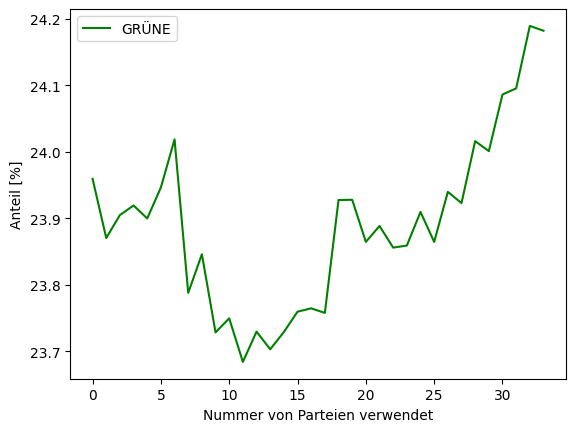

In [54]:
plt.plot(range(34),preds[:,1],color='green',label='GRÜNE')
plt.legend()
plt.xlabel("Nummer von Parteien verwendet")
plt.ylabel("Anteil [%]")

Text(0, 0.5, 'Anteil [%]')

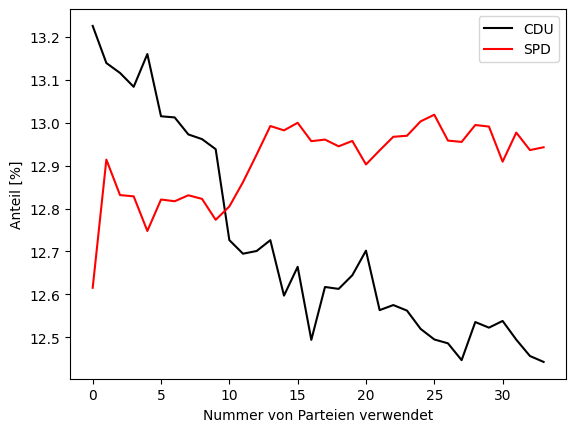

In [55]:
plt.plot(range(34),preds[:,0],color='black',label='CDU')
plt.plot(range(34),preds[:,2],color='red',label='SPD')
#plt.plot(range(34),preds[:,1],color='green',label='GRÜNE')
plt.legend()
plt.xlabel("Nummer von Parteien verwendet")
plt.ylabel("Anteil [%]")

Text(0, 0.5, 'Anteil [%]')

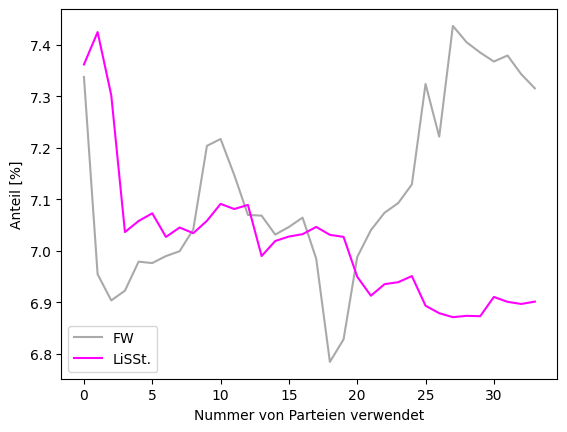

In [56]:
plt.plot(range(34),preds[:,5],color='darkgray',label='FW')
plt.plot(range(34),preds[:,6],color='magenta',label='LiSSt.')
plt.legend()
plt.xlabel("Nummer von Parteien verwendet")
plt.ylabel("Anteil [%]")

Text(0, 0.5, 'Anteil [%]')

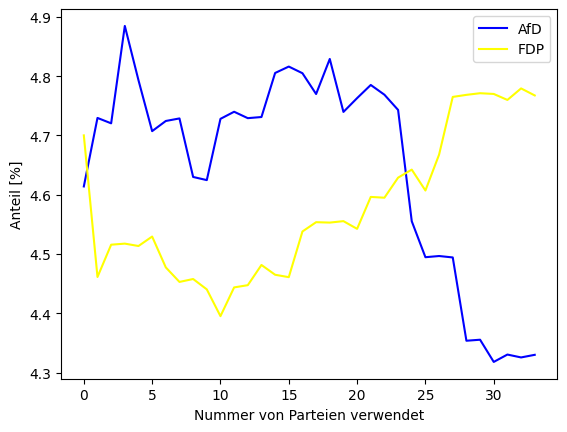

In [57]:
plt.plot(range(34),preds[:,3],color='blue',label='AfD')
plt.plot(range(34),preds[:,4],color='yellow',label='FDP')
plt.legend()
plt.xlabel("Nummer von Parteien verwendet")
plt.ylabel("Anteil [%]")

Text(0, 0.5, 'Anteil [%]')

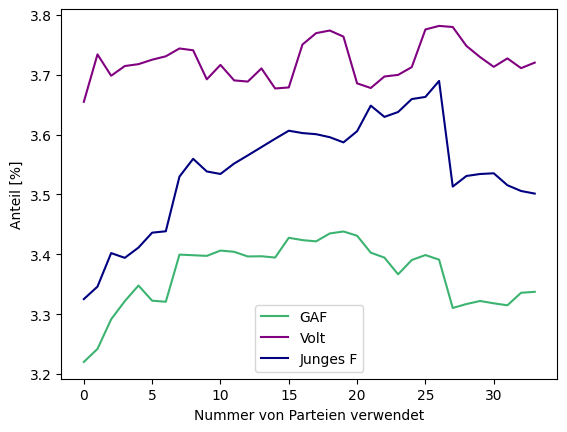

In [58]:
plt.plot(range(34),preds[:,8],color='mediumseagreen',label='GAF')
plt.plot(range(34),preds[:,10],color='purple',label='Volt')
plt.plot(range(34),preds[:,11],color='navy',label='Junges F')
plt.legend()
plt.xlabel("Nummer von Parteien verwendet")
plt.ylabel("Anteil [%]")

Text(0, 0.5, 'Anteil [%]')

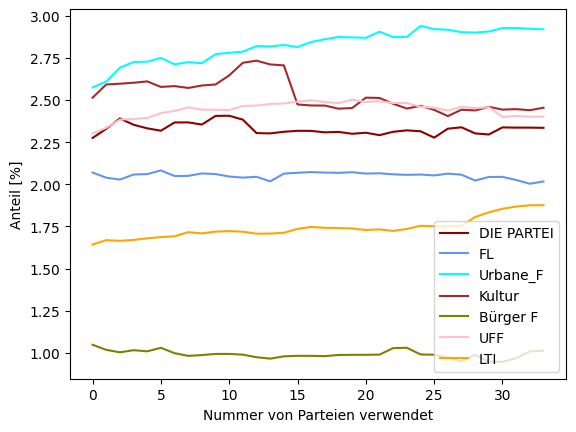

In [59]:
plt.plot(range(34),preds[:,7],color='darkred',label='DIE PARTEI')
plt.plot(range(34),preds[:,9],color='cornflowerblue',label='FL')
plt.plot(range(34),preds[:,12],color='cyan',label='Urbane_F')
plt.plot(range(34),preds[:,13],color='brown',label='Kultur')
plt.plot(range(34),preds[:,14],color='olive',label='Bürger F')
plt.plot(range(34),preds[:,15],color='pink',label='UFF')
plt.plot(range(34),preds[:,16],color='orange',label='LTI')
plt.legend()
plt.xlabel("Nummer von Parteien verwendet")
plt.ylabel("Anteil [%]")

Nun die Plots fuer ein und zwei Parteien Verwendung. 

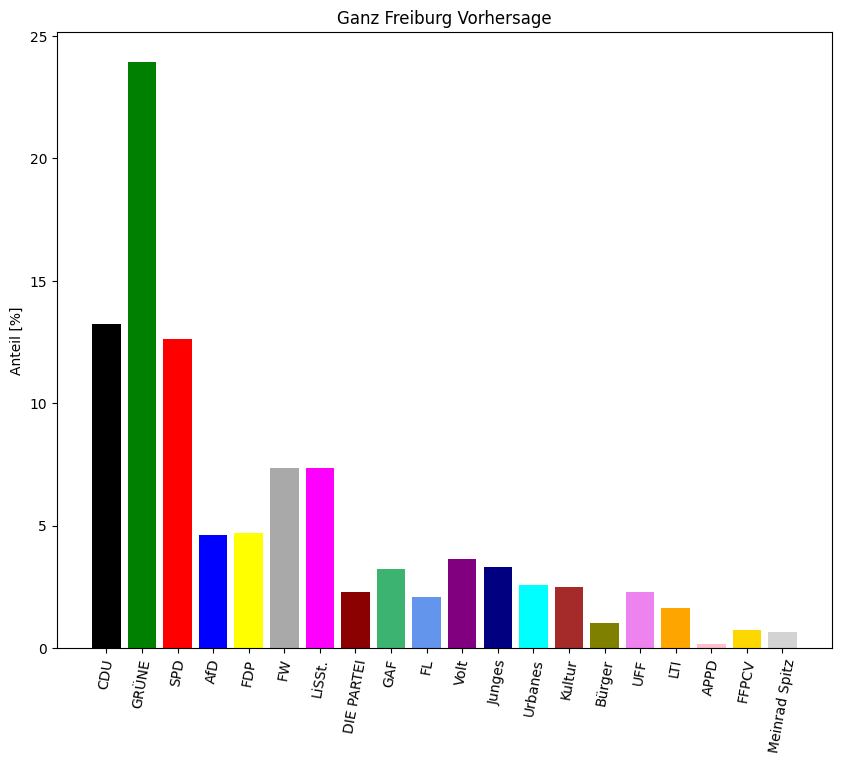

In [60]:
make_bar_plot(prediction_val,title='Ganz Freiburg Vorhersage')

Und zu dieser in Mitgliedern. 

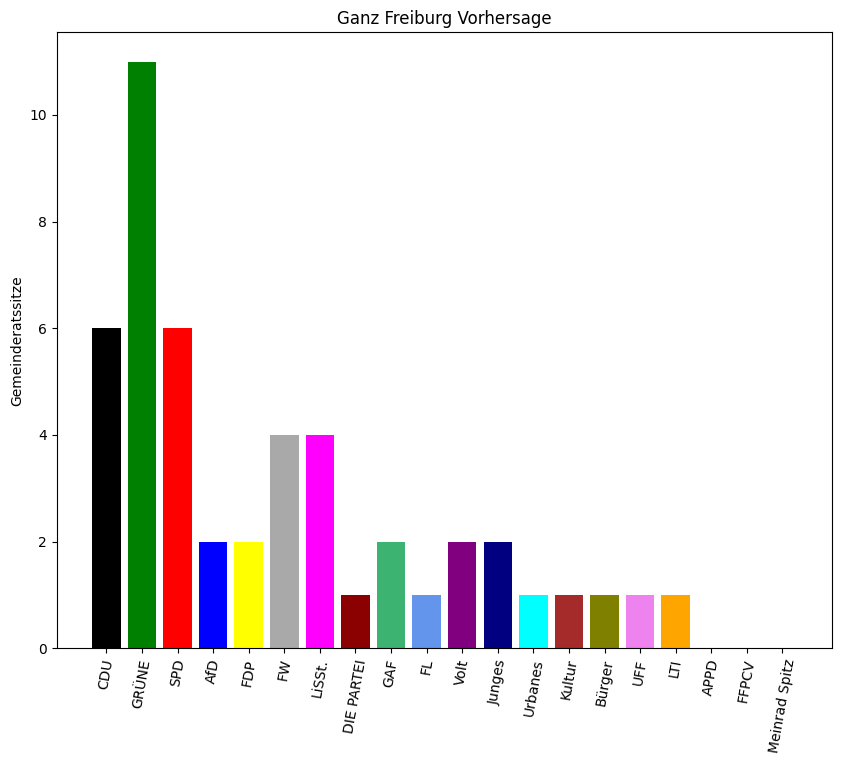

In [61]:
make_bar_plot(prediction_val,title='Ganz Freiburg Vorhersage',sitze=48)

Vergliechen mit dem Auszaehlungsstand am 10.6 gewinnen Linke Liste, GAF, Volt und Junges Freiburg ein Mandat waehrend CDU zwei verlieren,  Freie Waehler und  die AfD jeweils eines. 



Jetzt auch Verwendung von zweitbester Korrelation Partei. 

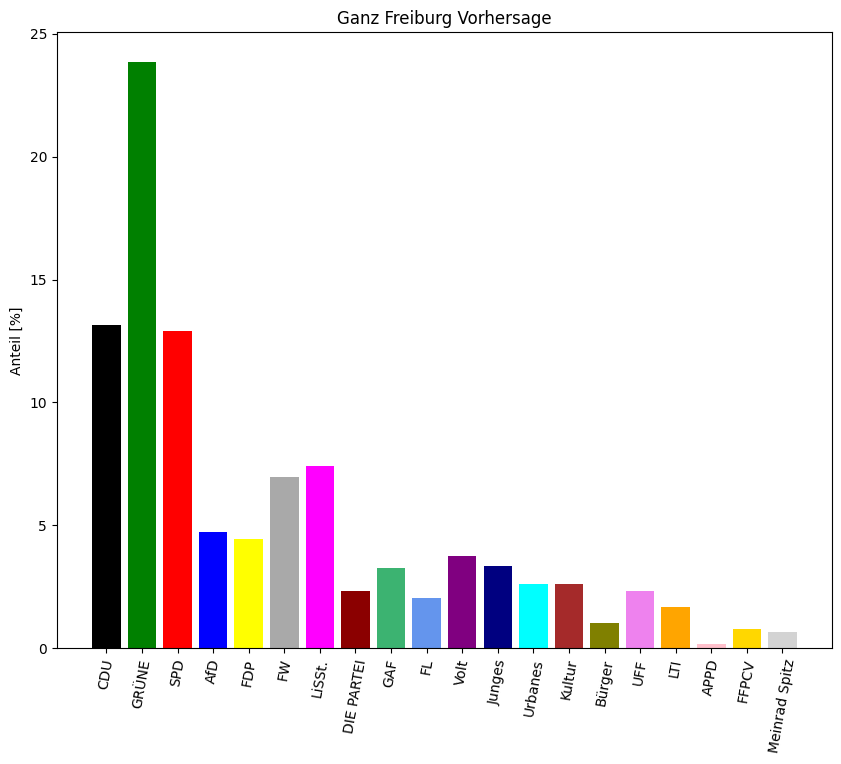

In [63]:
make_bar_plot(prediction_val2,title='Ganz Freiburg Vorhersage')

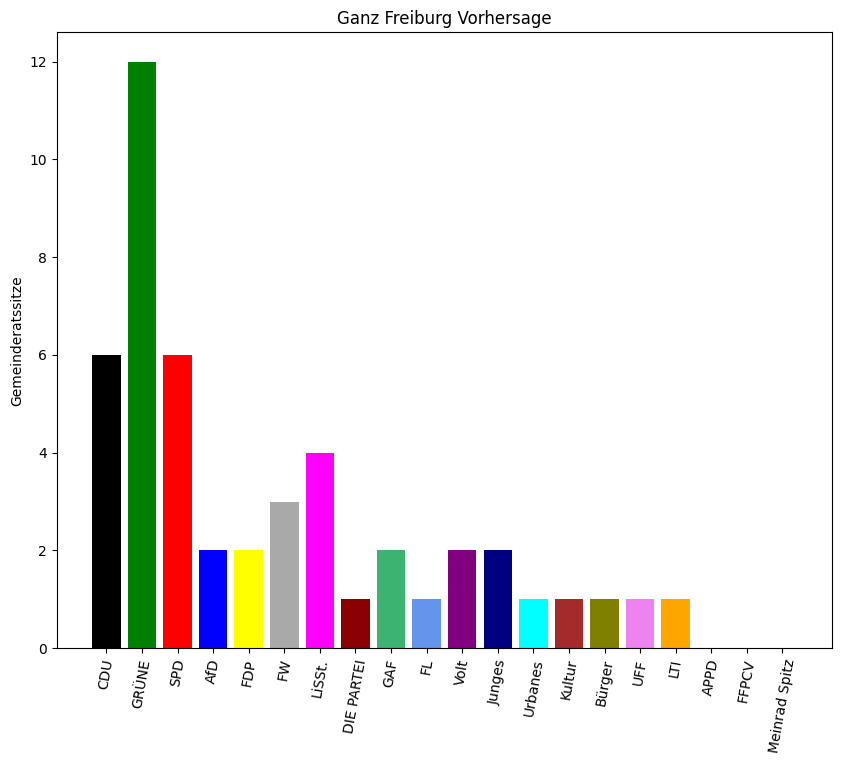

In [75]:
make_bar_plot(prediction_val2,title='Ganz Freiburg Vorhersage',sitze=48)

In [76]:
Das verschiebt ein Sitz von Freien Waehlern zu den Gruenen. 

Quadratische Function Verwendung. 

SyntaxError: invalid syntax (3791596729.py, line 1)

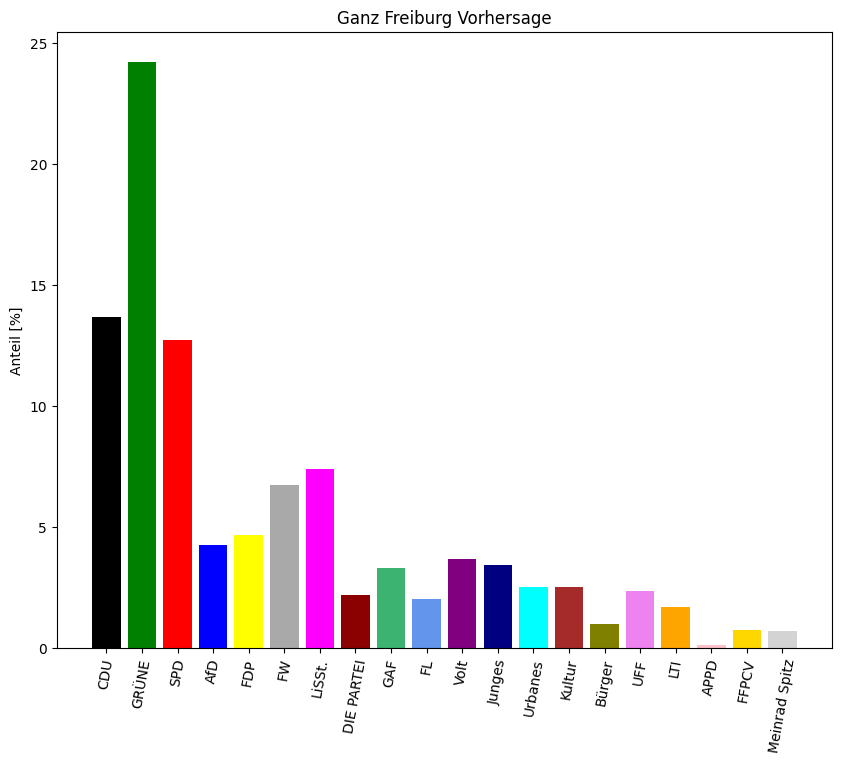

In [77]:
make_bar_plot(prediction_val_q,title='Ganz Freiburg Vorhersage')

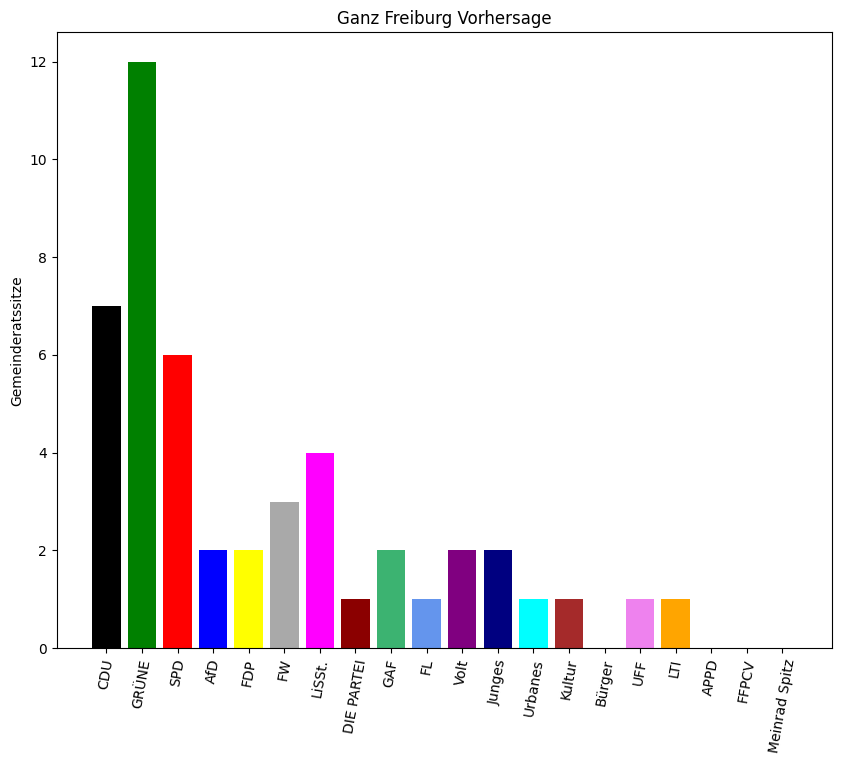

In [78]:
make_bar_plot(prediction_val_q,title='Ganz Freiburg Vorhersage',sitze=48)

In [ ]:
Aehnlich, ein Sitz mehr fuer CDU und keiner fuer Buerger F. 